[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stefanlessmann/lime_from_scratch/blob/main/LIME_from_scratch.ipynb) 

# LIME Verfahren nachgebaut 

In [1]:
# Datenstrukturen
import numpy as np
import pandas as pd

# Grafische Ausgabe
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
# Some configuration of the plots we will create later
%matplotlib inline  
class_coloring = plt.cm.bwr

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression


import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

rnd_state = 888

## Hilfsfunktionen
Die Demonstration des LIME-Verfahrens benötigt eine Reihe grafischer Ausgaben. Die Funktion in diesem Abschnitt stellen die hierzu nötige Funktionalität bereit. Jede Funktion kann einzelnd eingesehen und verändert werden. Gleichermaßen ist es ggf. nicht notwendig, den Code der Funktionen in allen Einzelheiten nachzuvollziehen, um die Funktionsweise von LIME nachzuvollziehen. 

### Datengenerierung

In [2]:
def make_Ripley(n=1000, mu1=[1,1], mu2=[4, 4], sig1=1, sig2=1):
    """ Erzeugt linear trennbare synthetische Daten
    """
    
    np.random_state = rnd_state
    
    class1_x1 = np.random.normal(loc=mu1[0], scale=sig1, size=n)
    class1_x2 = np.random.normal(loc=mu1[1], scale=sig1, size=n)

    class2_x1 = np.random.normal(loc=mu2[0], scale=sig2, size=n)
    class2_x2 = np.random.normal(loc=mu2[1], scale=sig2, size=n)

    y1 = np.repeat(0, n)
    y2 = np.repeat(1, n)

    class1 = np.vstack((class1_x1, class1_x2)).T
    class2 = np.vstack((class2_x1, class2_x2)).T

    X = np.vstack((class1,class2))
    y = np.concatenate((y1,y2))
    
    return X, y

### Grafische Darstellung

In [3]:
def plot_get_limits(D, delta=0.25):
    x1_lim = (np.min(D[:,0])-delta, np.max(D[:,0])+delta)
    x2_lim = (np.min(D[:,1])-delta, np.max(D[:,1])+delta)
    
    return (x1_lim, x2_lim)

In [4]:
def plot_init_axis(ax, title=None):
    
    if not title is None:
        ax.set_title(title, fontsize=16)
    ax.set_xlim(xy_limits[0][0], xy_limits[0][1])
    ax.set_ylim(xy_limits[1][0], xy_limits[1][1])
    ax.set_ylabel('$x_2$', fontsize=14)
    ax.set_xlabel('$x_1$', fontsize=14)

In [5]:
def plot_reg_line(ax, beta, bias, lw=5):
    # Plotting data
    x1 = np.linspace(xy_limits[0][0], xy_limits[0][1]) 
    x2 = - beta[0] / beta[1] * x1 - bias/beta[1]
    # Clipping
    ix = [i>xy_limits[1][0] and i < xy_limits[1][1] for i in x2]
    #ix = [i>x2_lim[0] and i < x2_lim[1] for i in x2]
    reg_line = np.c_[x1[ix], x2[ix]]
    # Plotting
    ax.plot(reg_line[:,0], reg_line[:,1], linewidth=lw, c='#FFFF00')
    return reg_line

In [6]:
def plot_data(ax, X, y, alpha=1, X_test=None, y_test=None):
    """ 2D Grafik des Klassifikationproblems"""
   
    # Plot the training & test points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=class_coloring, edgecolors='k', marker='o', alpha=alpha)
    #ax.set_xlabel("$x_1$")
    #ax.set_ylabel("$x_2$")
    if X_test is not None and y_test is not None:
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=class_coloring, edgecolors='k', marker='*', s=150, alpha=alpha)

In [7]:
def plot_synthetic(ax, X, y=None, weight=None, add_bar=False):
    """ 2D Grafik des Klassifikationproblems"""
    
    a = 0.7

    if y is None:
        ax.scatter(X[:,0], X[:,1], marker='^', c='k', s=weight, alpha=a)
    else:
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap=class_coloring, edgecolors='k', marker='^', s=weight, alpha=a)

    if add_bar:
        ax_c = plt.colorbar(plt.cm.ScalarMappable(cmap=class_coloring))
        ax_c.set_label("BB-Modell Schätzung von $p(y=1|X)$")
        ax_c.set_ticks([0, .25, .5, .75, 1])
        

In [8]:
def mesh_grid_orig(model, res = 0.01, mode='classification'):
    res = 0.01 # step size in the mesh
   
    xx, yy = np.meshgrid( np.arange(xy_limits[0][0], xy_limits[0][1], res),
                          np.arange(xy_limits[1][0], xy_limits[1][1], res)
                        )   
    if mode == 'classification':
        y_hat = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    elif mode =='regression':
        y_hat = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        raise(BaseException('Der Modus {} wird nicht unterstützt.'.format(mode)))
    y_hat = y_hat.reshape(xx.shape)
    return (xx, yy, y_hat)

In [9]:
def mesh_grid_data(res = 0.01):
    
    xx, yy = np.meshgrid( np.arange(xy_limits[0][0], xy_limits[0][1], res),
                          np.arange(xy_limits[1][0], xy_limits[1][1], res)
                        )   
    
    return (xx, yy)

In [10]:
def mesh_grid_prediction(model, res = 0.01, mode='classification'):
   
    data = mesh_grid_data(res)
    
    if mode == 'classification':
        y_hat = clf.predict_proba(np.c_[data[0].ravel(), data[1].ravel()])[:, 1]
    elif mode =='regression':
        y_hat = clf.predict(np.c_[data[0].ravel(), data[1].ravel()])
    else:
        raise(BaseException('Der Modus {} wird nicht unterstützt.'.format(mode)))
    y_hat = y_hat.reshape(data[0].shape)
    return (data[0], data[1], y_hat)

In [11]:
def plot_decision_surface(ax, clf, data=None, add_bar=False, binarize=False):
    
    if data is None:
        x1, x2, y_hat = mesh_grid_prediction(clf)
    else:
        (x1, x2, y_hat) = data
        
    if binarize:
            y_hat = y_hat >= 0.5
            
    contour = ax.contourf(x1, x2, y_hat, cmap=class_coloring, alpha=.5) # , vmin=0, vmax=1
    
    if add_bar:
        ax_c = plt.gcf().colorbar(contour)
        ax_c.set_label("$P(y=1|X)$")
        ax_c.set_ticks([0, .25, .5, .75, 1])
        

In [12]:
def plot_instance(ax, xi=None):
    """ Grafische Darstellung der zu erklärenden Instanz"""
    if xi is None:
        xi = Xi
        
    ax.scatter(xi[0,0], xi[0,1], marker='o', c='#FFFF00', edgecolors='k' ,s=250)           

In [13]:
def plot_wb_model_grid(ax, wb_model, resolution=0.2):
    data = mesh_grid_data(res=resolution)
    data = np.c_[data[0].ravel(), data[1].ravel()]
    y_hat = wb_model.predict(data)

    ax.scatter(data[y_hat>0,0], data[y_hat>0,1], c='r', marker='x')
    ax.scatter(data[y_hat<0,0], data[y_hat<0,1], c='b', marker='x')

In [45]:
def plot_explanation(ax, wb_model):
    dim = len(wb_model.coef_)
    labels = ('x1', 'x2')
    barcolor = np.repeat('r', dim)
    for i, w in enumerate(wb_model.coef_):
        if w < 0:
            barcolor[i]='b'

    y_pos = np.arange(dim)        
    ax.barh(y_pos, wb_model.coef_, align='center', color=barcolor)
    ax.set_xlabel('Koeffizient des Interpretationsmodells', fontsize=14)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)

In [15]:
def plot_reproduce_paper(test_instance, syn_x, syn_weights, bb_model, wb_model, img_name=None):
    """
    Repliziert die zentrale Grafik aus dem Ribeiro et al. (2016) Papier, welches
    die Funktionsweise von LIME illustriert.
    """
    # 2x2 Matrix der Grafiken
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(26, 26))
    axs = axs.reshape(-1)
    # 1. Entscheidungsfunktion des BB_models
    plot_init_axis(axs[0], 'A')
    plot_decision_surface(axs[0], bb_model)
   
    # 2. Entscheidungsfunktion des BB_models, synthetische Daten (ungewichtet und ohne label) und Testinstanz
    plot_init_axis(axs[1], 'B')
    plot_decision_surface(axs[1], bb_model)
    plot_instance(axs[1], xi=test_instance)
    plot_synthetic(axs[1], syn_x)
    
    # 3. Entscheidungsfunktion des BB_models, synthetische Daten (gewichtet und ohne label) und Testinstanz
    plot_init_axis(axs[2], 'C')
    plot_decision_surface(axs[2], bb_model)
    plot_instance(axs[2], xi=test_instance)
    plot_synthetic(axs[2], syn_x, weight=syn_weights*100)
    
    # 4. Entscheidungsfunktion des BB_models, Approximation durch interpretationsmodell, Testinstanz und Grid mit Klassifikation des linearen Modells
    plot_init_axis(axs[3], 'D')
    plot_decision_surface(axs[3], bb_model)
    plot_instance(axs[3], xi=test_instance)
    plot_reg_line(axs[3], wb_model.coef_, wb_model.intercept_)
    plot_wb_model_grid(axs[3], wb_model)
    
    if img_name is not None:
        plt.savefig(img_name, format='jpg')
    

In [16]:
def plot_lime_steps(test_instance, data_x, data_y, syn_x, syn_y, syn_weights, bb_model, wb_model, img_name=None):
    """
    Visualisierung der Schritte von LIME; angelehnt an die zentrale Grafik aus Ribeiro et al. (2016)
    """
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(26, 26), sharey=False)
    axs = axs.reshape(-1)
    ix = 0
    
    # Klassifikationsproblem
    plot_init_axis(axs[ix], 'Klassifikationsproblem und Entscheidungsfunktion des BB-Modells')
    plot_data(axs[ix], data_x, data_y)
    ix += 1
        
    # Entscheidungsfunktion des BB_models
    plot_init_axis(axs[ix], 'Entscheidungsfunktion des BB-Modells')
    plot_data(axs[ix], data_x, data_y)
    plot_decision_surface(axs[ix], bb_model)
    ix+= 1
      
    # Testinstanz und synthetische Daten (ungewichtet und ohne label)
    plot_init_axis(axs[ix], 'Testinstanz und synthetische Daten als NV-Zufallszahlen')
    plot_decision_surface(axs[ix], bb_model)
    plot_instance(axs[ix], xi=test_instance)
    plot_synthetic(axs[ix], syn_x)
    ix += 1
    
    # Gewichtung der synthetischen Daten 
    plot_init_axis(axs[ix], 'Distanzgewichtete synthetische Daten')
    plot_decision_surface(axs[ix], bb_model)
    plot_instance(axs[ix], xi=test_instance)
    plot_synthetic(axs[ix], syn_x, weight=syn_weights*100)
    ix += 1
    
    # Verteilung der Zielvariablen 
    axs[ix].set_title('Verteilung der Zielvariablen für das WB-Modell', fontsize=16)
    axs[ix].hist(y_syn)
    ix += 1
    
    # Synthetische Daten mit Label
    plot_init_axis(axs[ix], 'Synthetische Daten inkl. Zielvariable durch das BB-Modell')
    plot_instance(axs[ix], xi=test_instance)
    plot_synthetic(axs[ix], syn_x, syn_y, weight=syn_weights*100, add_bar=True)
    plot_reg_line(axs[ix], wb_model.coef_, wb_model.intercept_)
    ix += 1
   
    plt.show()
    fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(26, 10), sharey=False)
    axs = axs.reshape(-1)
    ix = 0
    
    # Lineare, lokale Approximation des BB-Modells
    plot_init_axis(axs[ix], 'Lineare, lokale Approximation des BB-Modells')
    plot_decision_surface(axs[ix], bb_model)
    plot_instance(axs[ix], xi=test_point)
    plot_reg_line(axs[ix], wb_model.coef_, wb_model.intercept_)
    plot_wb_model_grid(axs[ix], wb_model)
    ix += 1

    # LIME Erklärung
    axs[ix].set_title('LIME Erklärung', fontsize=16)
    plot_explanation(axs[ix], wb_model)
    
    if img_name is not None:
        fig.savefig(img_name, format='jpg')
        
    plt.show()

## Datengenerierung

### Daten für die nichtlineare Klassifikation 

In [17]:
n_real_data = 500
X, y = make_moons(n_samples=n_real_data, noise=0.3, random_state=rnd_state)

### Synthetische Daten für die Schätzung des Interpretationsmodells
LIME erzeugt synthetische Daten unabhängig von der zu interpretierenden Instanz. Daher können die synthetischen Daten direkt zu beginn erzeugt werden. Dazu werden normalverteilte Daten zufällig gezogen.

In [18]:
n_syn_data =  500

mean_x = np.mean(X, axis=0)
s_x = np.std(X, axis=0)
np.random_state = rnd_state
X_syn = np.random.normal(loc=0, scale=1, size=n_syn_data*2).reshape(n_syn_data, 2)
X_syn = X_syn * s_x + mean_x

## Klassifikationsproblem

### Datengrundlage

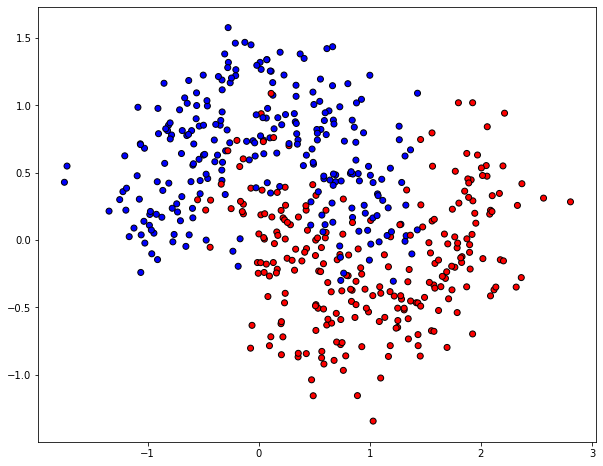

In [19]:
xy_limits = plot_get_limits( np.row_stack((X, X_syn)))

fig, ax = plt.subplots(figsize=(10, 8))
#plot_init_axis(ax, 'Synthetisches, nichtlinerares Klassifikationsproblem in 2D')
plot_data(ax, X, y)

### Training des nichtlineraren Klassifikators (BB-Modell)

In [20]:
# Klassifikator
#clf = XGBClassifier(learning_rate=0.01, n_estimators=250, random_state=rnd_state)
clf = MLPClassifier(hidden_layer_sizes=(100, 25), max_iter=500, random_state=rnd_state)
#clf = MLPClassifier(random_state=rnd_state)

BB_model = clf.fit(X, y)
y_syn = BB_model.predict_proba(X_syn)[:,1]

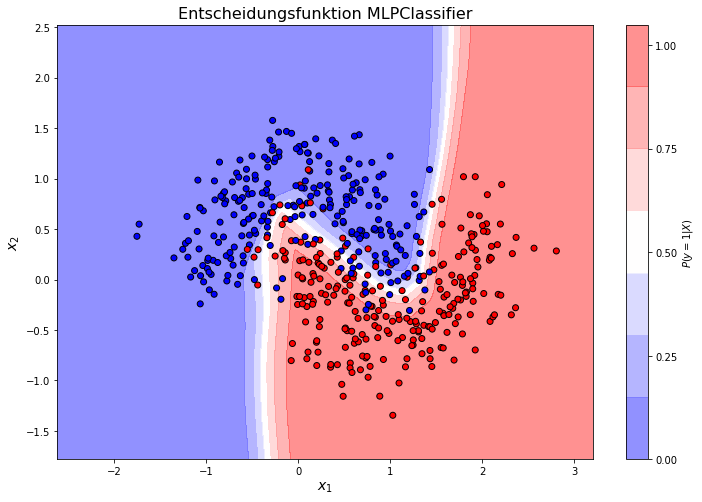

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
plot_init_axis(ax, 'Entscheidungsfunktion {}'.format(type(BB_model).__name__))
plot_decision_surface(ax, BB_model, add_bar=True)
plot_data(ax, X, y)

## Lokale Interpretation mit LIME


### Zu erklärende Instanz festlegen

In [22]:
Xi = np.array([0.8, 0.5]).reshape(-1, 2)
p_Xi = BB_model.predict_proba(Xi).ravel()[1]
print('BB-Prognose der zu erklärenden Instanz ist: {:.4}'.format(p_Xi))

BB-Prognose der zu erklärenden Instanz ist: 0.03878


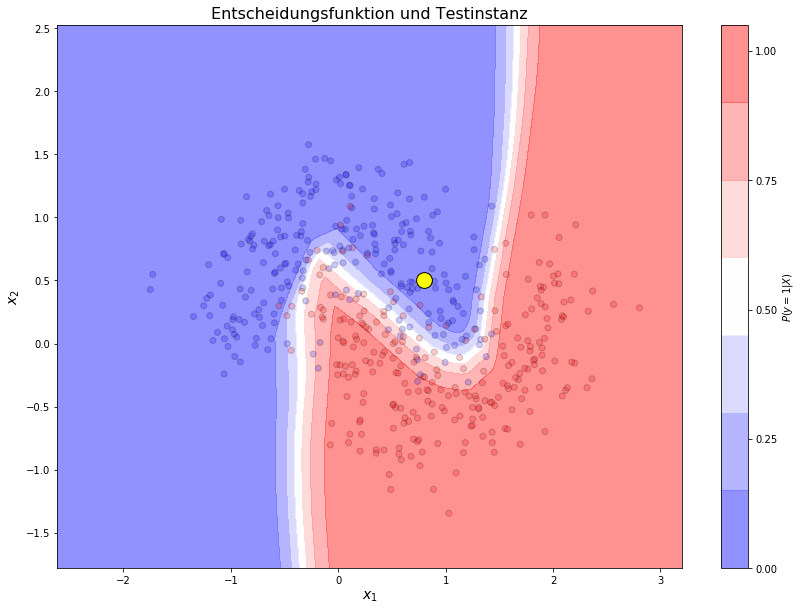

In [23]:
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Entscheidungsfunktion und Testinstanz'.format(type(BB_model).__name__))
plot_decision_surface(ax, BB_model, add_bar=True)
plot_data(ax, X, y, alpha=.2)

# Instanz hinzufügen
plot_instance(ax)

### BB-Prognose in der Nachbarschaft von Xi

In [24]:
delta = 0.3
Xi_test = np.array(Xi+[delta, 0.0]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14)
Xi_test = np.array(Xi+[0.0, delta]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14)
Xi_test = np.array(Xi+[-delta, 0.0]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14)
Xi_test = np.array(Xi+[0.0, -delta]).flatten()
ax.scatter(Xi_test[0], Xi_test[1], marker='o', c='#FFFF00', edgecolors='k' ,s=25);
ax.annotate('{:.3}'.format(clf.predict_proba(Xi_test.reshape(1,2))[0][1]), (Xi_test[0], Xi_test[1]), fontsize=14);

### Synthetische Daten und BB-Modellprognose 

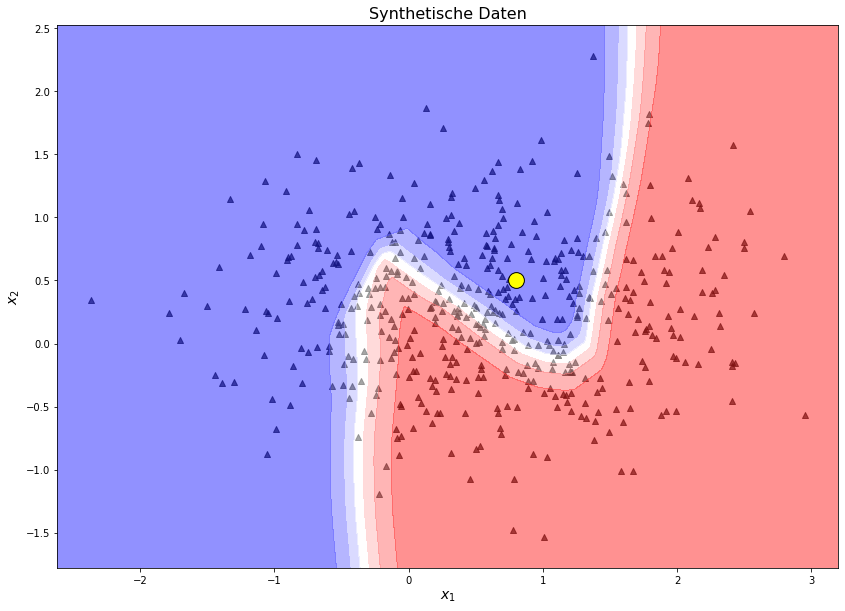

In [25]:
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Synthetische Daten')
plot_synthetic(ax, X_syn)
plot_decision_surface(ax, BB_model)
plot_instance(ax)

### Nachbarschaft und Gewichtung 

#### Berechnung der paarweisen Anstände zwischen synthetischen Daten und Testinstanz

In [26]:
distances = pairwise_distances(X_syn, Xi).ravel()
distances.shape

(500,)

#### Kernfunktion

In [27]:
def kernel_fn(dist, kernel_width=0):
    if kernel_width == 0:
        kernel_width=np.sqrt(2) * 0.75
        
    return np.sqrt(np.exp(-(dist ** 2) / 0.5 ** 2))

sim = kernel_fn(distances)

#### Datengrundlage für das Erklärungsmodell

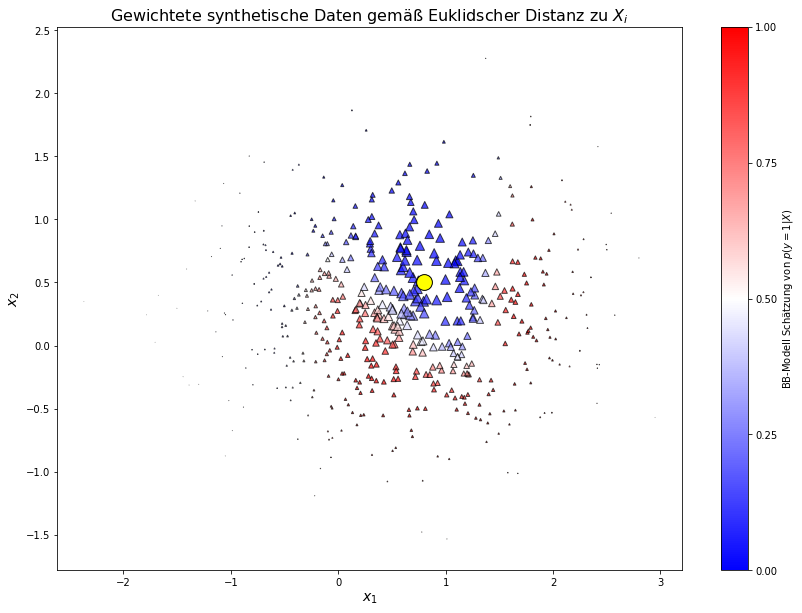

In [28]:
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Gewichtete synthetische Daten gemäß Euklidscher Distanz zu $X_i$')
plot_synthetic(ax, X_syn, weight=sim*100, y=y_syn, add_bar=True)
plot_instance(ax)

Die Abbildung deutet bereits an, dass die Zielvariable eine bimodale Verteilung besitzt, was die Approximation des BB-Modells mit einer linearen Regression erschweren dürfte. Die problematische Verteilung zeigt auch folgendes Histogram.

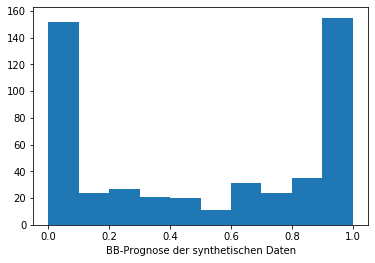

In [29]:
plt.hist(y_syn)
plt.xlabel('BB-Prognose der synthetischen Daten');


### Schätzung des Interpretationsmodells

In [30]:
#lin_reg = Ridge(alpha=1, fit_intercept=True)
lin_reg = LinearRegression(fit_intercept=True)
WB_model = lin_reg.fit(X_syn, y_syn, sample_weight=sim)
y_wb_syn = WB_model.predict(X_syn)

print('Parameter der linearen Regressionsfunktion: ', WB_model.coef_, WB_model.intercept_)

resid = y_syn - y_wb_syn 
print('Gewichtetet quadratischer Fehler = {:.4}'.format(np.sum((resid**2)*sim)/len(y_syn)))
print('Erklärte Varianz (ungewichtet) = {:.4}'.format(1-np.sum(resid**2)/np.sum((y_syn - np.mean(y_syn))**2)))

Parameter der linearen Regressionsfunktion:  [-0.05797905 -0.63568264] 0.6484092814806048
Gewichtetet quadratischer Fehler = 0.01621
Erklärte Varianz (ungewichtet) = -0.006772


### Ergebnis von LIME

Schätzung BB-Modell [0.03878213]
Schätzung Interpretationsmodell [0.28418473]


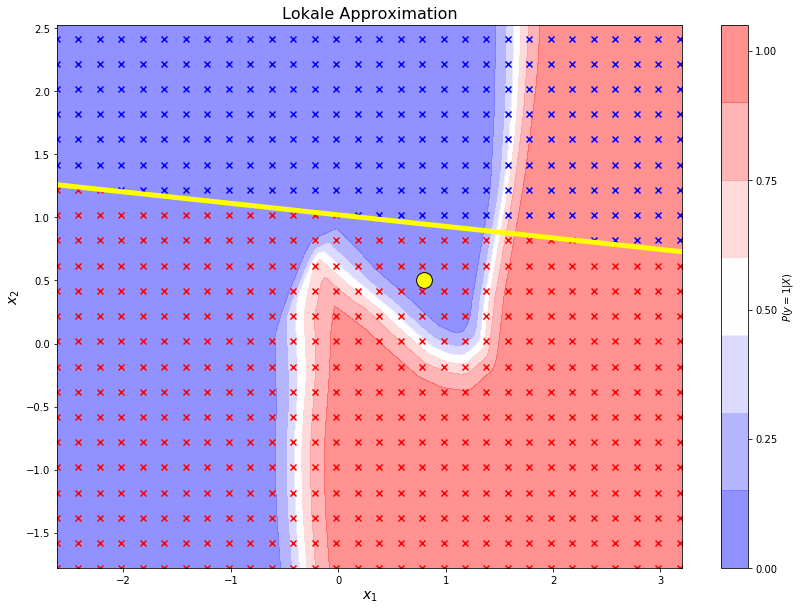

In [31]:
print('Schätzung BB-Modell {}'.format(BB_model.predict_proba(Xi)[:,1]))
print('Schätzung Interpretationsmodell {}'.format(WB_model.predict(Xi)))

# Ready to plot our hyperplane
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Lokale Approximation')
plot_decision_surface(ax, BB_model, add_bar=True)
plot_reg_line(ax, beta=WB_model.coef_, bias = WB_model.intercept_)
plot_instance(ax)

plot_wb_model_grid(ax, WB_model)

# LIME Demo und Experimente

## LIME-Verfahren
Der LIME-Algorithmus wird in der Funktion `LIME_demo()` implementiert. Die Funktion besteht im Wesentlichen aus fünf Schritten.
### 1. Synthetische Daten
Synthetische Daten werden für die Schätzung des Interpretationsmodells benötigt. In diesem Beispiel werden diese Daten als normalverteilte Zufallszahlen gezogen. Für jedes der beiden Merkmale werden die Parameter der Normalverteilung entsprechend des Mittelwertes und der Standardabweichung dieses Merkmales in den Klassifikationsdaten festgelegt. 
### 2. Prognose durch BB-Modell
Für das Interpretationsmodell wird eine Zielvariable benötigt. Dazu werden die zuvor erzeugten synthetischen Daten mit dem BB-Modell prpgnostiziert. Die Zielvariable entspricht dann der Schätzung $ \hat{p} \left( y_j=1|Z_j \right) $ durch das BB-Modell. 

### 3. Nachbarschaft und Gewichtung
Die synthetischen Daten werden entsprechend ihrer Distanz zur Testinstanz gewichtet. Wir verwenden dazu die Euklidsche Distanz $D\left(X_i,Z_j\right)=||X_i-Z_j||_2$. Dies entspricht dem Standard für strukturierte Daten im [offiziellen LIME Paket](https://github.com/marcotcr/lime). Mit Hilfe der so gewonnenen Distanzen wird eine Nachbarschaft zur Testinstanz definiert. Dazu wird - wieder entsprechen dem Standard im LIME-Paket - eine exponentielle Kernfunktion verwendet. 
$$ \pi_{X_i}\left( Z_i \right)=\exp \left( - \frac{D\left(X_i,Z_j\right)}{\sigma^2}\right)$$

### 4. Schätzung des Interpretationsmodells
Wir verwenden ein lineares Modell für die Erklärung der BB-Prognose der Testinstanz. LIME verwendet standardmäßig ein regularisiertes lineares Modell. Da wird im Beispiel mit nur zwei Merkmalen arbeiten verzichten wir auf eine Regularisierung und vernwedet ein multivariates lineares Regressionsmodell für die Interpretation. Dieses Modell schätzen wir durch Minimierung der *gewichteten* Likelihoodfunktion.
$$ \mathcal{L} \left( f, g, \pi_{X_i} \right) = \sum_{j=1}^{J} \pi_{X_i}\left( Z_i \right) \left( f\left( Z_j \right)- g \left( Z_j \right)  \right)^2 $$

### 5. Ausgabe der Ergebnisse
Die Funktion liefert verschiedene Ergebnisse, welche sich an dem Papier von [Ribeiro et al. (2016)](https://doi.org/10.1145/2939672.2939778) und dem [offiziellen LIME Paket](https://github.com/marcotcr/lime) orientieren. Hierzu gehören die Prognose der Testinstanz durch das BB-Modell sowie das Interpretationsmodell und eine Reihe von Grafiken, welche die Funktionsweise von LIME illustrieren. Weitere Einzelheiten entnehmen Sie bitte direkt dem Quellcode der Funktion.

### Funktion `LIME_Demo()` 

In [32]:
def LIME_demo(X, y, test_point, BB_model, n_syn_data, kernel_width, rep_paper_plot=True, fname=None):
    """
    Vereinfachte Implementierung des LIME-Verfahrens gemäß Ribeiro et al. (2016)
    http://doi.org/10.1145/2939672.2939778
    
    Eingabeparameter:  X = Matrix der unabhängigen Variablen für die Klassifikation
                       y = Vektor mit den Ausprägungen der Zielvariable der Fälle in X
                       
                       test_point = die zu erklärende Testinstanz 
                       
                       BB_model = sklearn Objekt des bereits trainierten Klassifikators
                       
                       n_syn_data = Anzahl der synthetischen Daten (Stichprobengröße)
                       
                       kernel_width = Parameter der expoentiellen Kernfunktion
                       
                       rep_paper_plot = Bool'scher Wert. Wenn wahr, besteht die Grafik-
                                        ausgabe der Funktion aus vier Grafiken, die sich
                                        direkt an dem LIME Papier orientieren. Andernfalls
                                        wird eine individualisierte Ausgabe bestehend aus
                                        sechs Grafiken erzeugt.
                                        
                      fname = Name (ggf. inkl. Pfad) unter dem die Grafik als Bilddatei 
                            gespeichert werden soll. Falls <None> wird keine Datei gespeichert. 
    
    Autor: Stefan Lessmann (stefan.lessmann@hu-berlin.de)
    
    Lizenz: BSD 2-clause "Simplified" license 
    
    Version: Januar 2021
    """    
    # *******************************************************************************************
    # 
    # Schritt 1: Synthetische Daten erzeugen
    # 
    # *******************************************************************************************
    # Bei tabellarischen Daten spielt die Nähe zur Testinstanz an dieser Stelle keine Rolle. Die
    # Daten werden als normalverteilte Zufallszahlen erzeugt. Die beiden Merkmale sind unkorreliert
    np.random_state = rnd_state
    X_syn = np.random.normal(loc=0, scale=1, size=n_syn_data*2).reshape(n_syn_data, 2)  # Standardnormalverteilte ZV
    # Skalierung entsprechend der Merkmale
    X_syn = X_syn * np.std(X, axis=0) + np.mean(X, axis=0)
    # Aktualisierung der Skalierung des Koordinatensystems für grafische Darstellungen
    xy_limits = plot_get_limits( np.row_stack((X, X_syn)), delta=0)  
    # *******************************************************************************************
    # 
    # Schritt 2: Prognose der synthetischen Daten mit dem BB-Modell, um eine Zielvariable für
    #            das Erklärungsmodell zu erhalten
    # 
    # *******************************************************************************************
    y_syn = BB_model.predict_proba(X_syn)[:,1]
    # *******************************************************************************************
    # 
    # Schritt 3: Abstände zwischen der Testinstanz und den synthetischen Daten ermitteln. Auf 
    #            diese Weise wird die Nachbarschaft der Testinstanz bestimmt
    # 
    # *******************************************************************************************
    dist = pairwise_distances(X_syn, test_point).ravel()  # Paarweise Anstände zur Testinstanz
    weights = np.sqrt( np.exp(-(dist ** 2) / kernel_width ** 2))  # Nachbarschaft
    # *******************************************************************************************
    # 
    # Schritt 4: Schätzen des linearen Interpretationsmodells auf den synthetischen Daten.
    #            Da es nur zwei Merkmale gibt, verzichten wir auf eine Regularisierung des 
    #            linearen Regressionsmodells.
    # 
    # *******************************************************************************************
    lin_reg = LinearRegression(fit_intercept=True)   
    WB_model = lin_reg.fit(X_syn, y_syn, sample_weight=weights)  # Min. der gewichteten LL-Funktion
    y_wb_syn = WB_model.predict(X_syn)  # Vorhersagen des Interpretationsmodells
    resid = y_syn - y_wb_syn            # und Residuen
    # *******************************************************************************************
    # 
    # Schritt 5: Ausgabe der Ergebnisse
    # 
    # *******************************************************************************************    
    # Textuelle Zusammenfassung
    print('Testinstanz: ', test_point)
    print('Parameter des WB Modells: ', WB_model.coef_.ravel(), WB_model.intercept_)
    print('Gewichtetet quadratischer Fehler = {:.4}'.format(np.sum((resid**2)*weights)/len(y_syn)))
    print('Prognose der Testinstanz durch BB-Modell {}'.format(BB_model.predict_proba(test_point)[:,1]))
    print('Approximation durch WB-Modell {}'.format(WB_model.predict(test_point)))
    print('\n\n')
    #--------------------------------------------------------------------------------------------
    # Visualisierungen
    #--------------------------------------------------------------------------------------------
    if rep_paper_plot:
        plot_reproduce_paper(test_point, syn_x=X_syn, syn_weights=weights, bb_model=BB_model, wb_model=WB_model, img_name=fname)
    else:
        plot_lime_steps(test_point, X, y, syn_x=X_syn, syn_y=y_syn, syn_weights=weights, bb_model=BB_model, wb_model=WB_model, img_name=fname)

## Konfigurationseinstellungen

Testinstanz:  [[1.  0.5]]
Parameter des WB Modells:  [ 0.07017297 -0.6736785 ] 0.5380472257497351
Gewichtetet quadratischer Fehler = 0.02147
Prognose der Testinstanz durch BB-Modell [0.00253911]
Approximation durch WB-Modell [0.27138095]





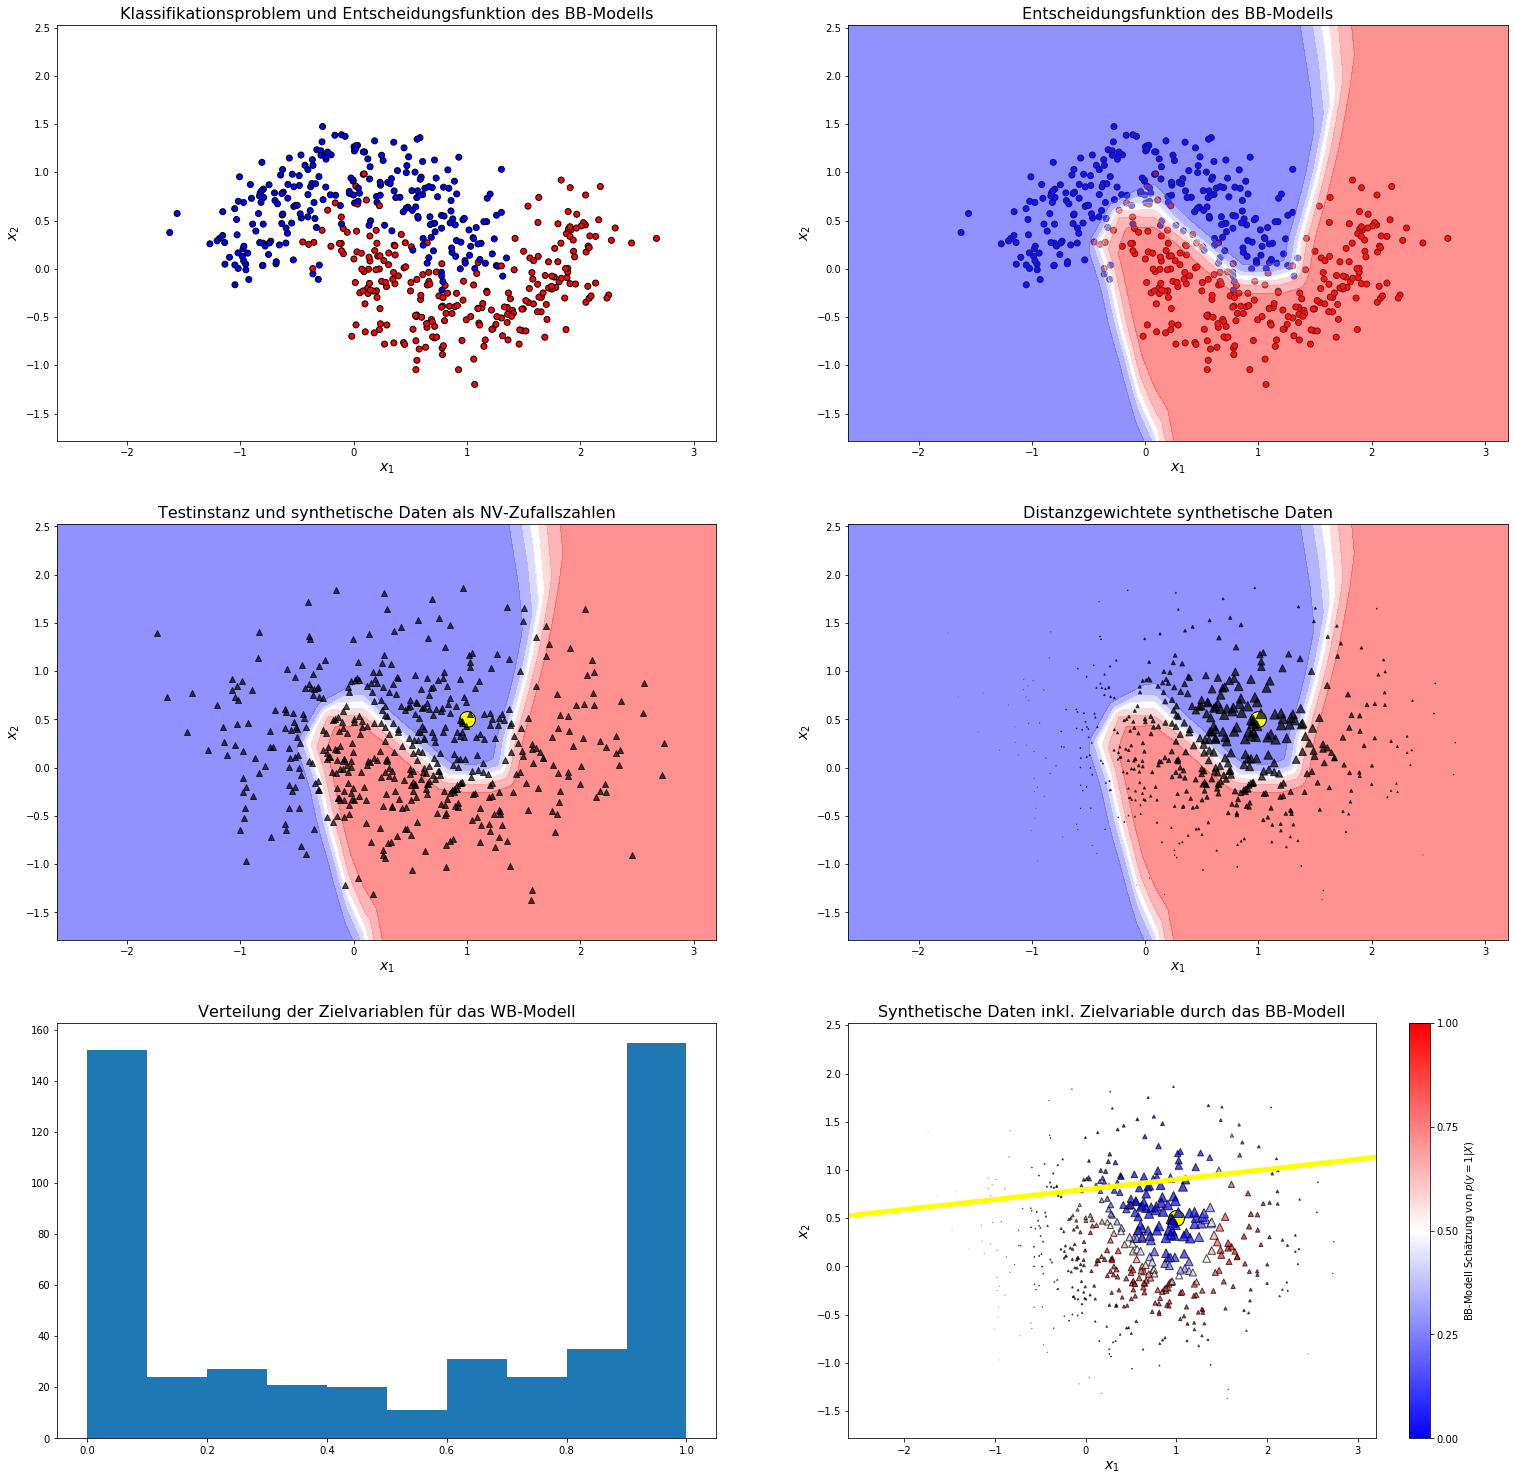

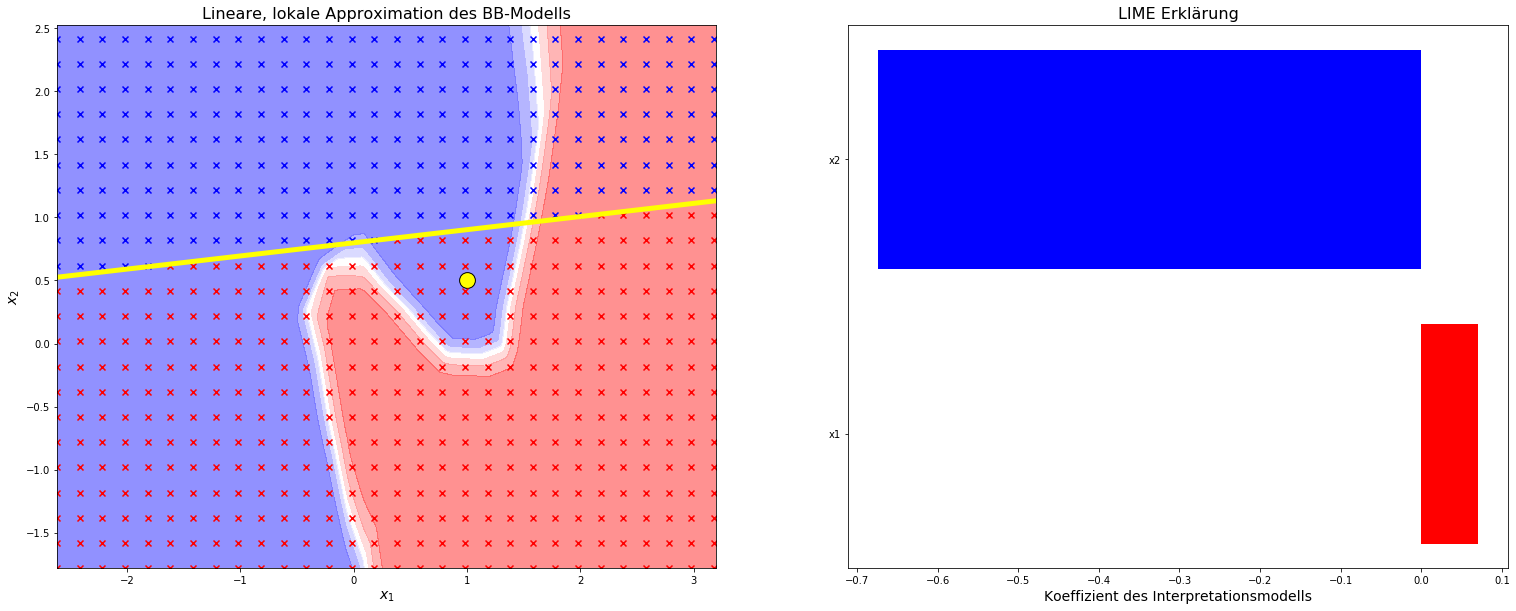

In [46]:
# Originaldate für die Klassifikation
n_real_data = 500 # Anzahl der Fälle 

# Ripley data set (einfaches lineares Klassifikationsproblem)
#X, y = make_Ripley(n=n_real_data, mu1=[0,0], mu2=[3, 3], sig1=2, sig2=1)

# Moon data set (nichtlineares Klassifikationsproblem)
X, y = make_moons(n_samples=n_real_data, noise=0.25, random_state=rnd_state)

# Synthetische Daten für das Schätzen des linearen Interpretationsmodells
n_syn_data = 500  # Anzahl der Fälle für die synthetischen Daten, welche LIME erzeugt
kernel_width = 0.5 # Parameter \sigma in der exponentiellen Kernfunktion

# Nichtlinerare Klassifikatoren (BB-Modelle)
#clf = XGBClassifier(learning_rate=0.01, n_estimators=250, random_state=rnd_state)
#clf = MLPClassifier(random_state=rnd_state)
clf = MLPClassifier(hidden_layer_sizes=(100, 25), max_iter=500, random_state=rnd_state)

# Trainieren des BB-Modells
BB_model = clf.fit(X, y)

# Die zu reklärende Instanz
test_point = [1, 0.5]#[1.75, 0.75] 
test_point = np.array(test_point).reshape(1, -1)  

LIME_demo(X, y, test_point, BB_model, n_syn_data, kernel_width, rep_paper_plot=False)

# Das offizielle LIME Paket

## Testinstanz erklären

In [35]:
import lime
from lime.lime_tabular import LimeTabularExplainer

# Erzeugen der Instanz der Erklärungsklasse für tabellarische Daten
lime_explainer = LimeTabularExplainer(X, mode="classification", feature_names=['x1', 'x2'], categorical_features=None, verbose=True, discretize_continuous=False)

pred_fun = clf.predict_proba  # Prognosefunktion des BB-Modells
k=2

# Aufruf der Erklärungsfunktion
exp_rf = lime_explainer.explain_instance(data_row=Xi.ravel(), predict_fn=pred_fun, num_features=k)
# Ausgabe der Ergebnisse direkt im Notebook
exp_rf.show_in_notebook(show_table=True, show_predicted_value= True)

Intercept 0.4910098885270734
Prediction_local [0.35453614]
Right: 0.005565859655102207


## LIME Erklärungsmodell extrahieren

In [36]:
# Datenstruktur
print(exp_rf.local_exp)

# Beta extrahieren
xb=0
lime_beta=np.zeros(2)
for ix, tup in enumerate(exp_rf.local_exp[1]):
    xb += Xi[0][tup[0]] * tup[1]
    lime_beta[tup[0]]=tup[1]

# Lokale Prognose verifizieren    
xb+exp_rf.intercept[1] - exp_rf.local_pred[0]
#np.sum(lime_beta)+exp_rf.intercept[1] - exp_rf.local_pred[0]

{1: [(1, -0.33880352593339813), (0, 0.06073543177972221)]}


0.015660329718833577

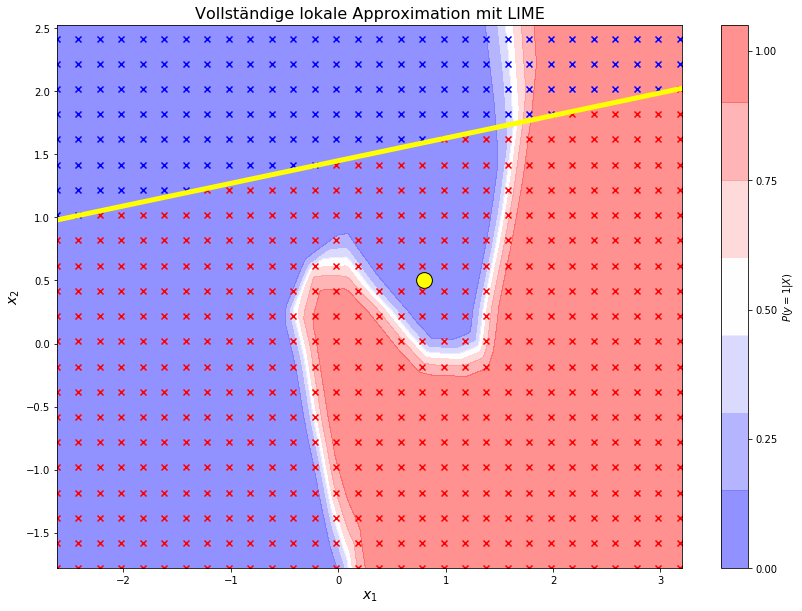

In [37]:
# Grafische Ausgabe analog zur obigen, eigenen Implementierung
fig, ax = plt.subplots(figsize=(14,10))
plot_init_axis(ax, 'Vollständige lokale Approximation mit LIME')
plot_decision_surface(ax, BB_model, add_bar=True)
plot_reg_line(ax, beta=lime_beta, bias = exp_rf.intercept[1])
plot_instance(ax)

data = mesh_grid_data(res=0.2)
data = np.c_[data[0].ravel(), data[1].ravel()]
y_hat = np.dot(data, lime_beta.reshape(-1,1)) + exp_rf.intercept[1]
y_hat = y_hat.ravel()

ax.scatter(data[y_hat>0,0], data[y_hat>0,1], c='r', marker='x')
ax.scatter(data[y_hat<0,0], data[y_hat<0,1], c='b', marker='x')
plt.show();